# This notebook contains code to check which model performs better on given data

### Import data

For this project I used dataset from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data) that was collected from website with detailed statistic [Basketball reference](https://www.basketball-reference.com/). The main datasets that we will use are `games.csv` (games information) and `teams.csv` (teams information for convenient visualization). However, I added 2 extra files with season schedule (`season_schedule.csv`) and teams participating in Play-Off for given seasons (`play_off_teams.csv`). Of course Play-off pairs generation may be automated, because there is table with team ranking but we would need to apply many filters to get useful information and handle situations if some teams have the same number of wins in season, so let us use hand-written data for now.

#### Games information

Let us ppreprocess data right away:
* Scale columns with team IDs because initially this column contained 10-digit numbers, but there are only 30 teams in NBA
* Drop columns **TEAM_ID_home** and **TEAM_ID_away** because the just duplicated teams IDs from columns **HOME_TEAM_ID** and **VISITOR_TEAM_ID** respectively
* Table contains incomplete information for games before 2004, so we keep games only after that year

Now let us analyze the data  to understand what we have here 
+ **GAME_DATE_EST**: date of the game, this will be used to distinguish regular season games from play-off games
- **GAME_ID**: not really useful column, we will drop it later
- **GAME_STATUS_TEXT**: also not useful column, *Final* just means that game has finished (*e.g.* we load data during the game, the status would be different)
+ **HOME_TEAM_ID**: ID of home team, we will use it
+ **VISITOR_TEAM_ID**: ID of visitor team, also will use it
+ **SEASON**: season year, will also be used to sort games for given season (but can use just first column)
- **PTS_home**: number of points home team earned, this column will not be used because in that case all other columns are not neccessary
+ **FG_PCT_home**: percentage of successfull shot attempts of home team
+ **FT_PCT_home**: percentage of successfull free-throw (after foul) attempts of home team
+ **FG3_PCT_home**: percentage of successfull 3-point shot attempts of home team
+ **AST_home**: number of assists of home team, it shows how good the ball movement is, so we will use this column
+ **REB_home**: number of rebounds of home team, it shows how good team gets the ball after failed shot attempt during attack and defense, so we also need this column
- **PTS_away**: number of points visitor team earned, also will not be used by the same reason
+ **FG_PCT_away**: percentage of successfull shot attempts of visitor team
+ **FT_PCT_away**: percentage of successfull free-throw (after foul) attempts of visitor team
+ **FG3_PCT_away**: percentage of successfull 3-point shot attempts of visitor team
+ **AST_away**: number of assists of visitor team
+ **REB_away**: number of rebounds of visitor team
+ **HOME_TEAM_WINS**: 1 - home team wins, 0 - otherwise. This will be our target

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

df_games = pd.read_csv('data/games.csv').drop(["TEAM_ID_home", "TEAM_ID_away"], axis=1) # open data without 2 columns wit hteam IDs
df_games = df_games.loc[df_games["SEASON"] >= 2004] # store games starting from season 2004

scaler = MinMaxScaler()
cols_to_norm = ["HOME_TEAM_ID", "VISITOR_TEAM_ID"]
df_games.loc[:, cols_to_norm] = scaler.fit_transform(df_games.loc[:, cols_to_norm]) # scale team IDs
df_games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0.103448,0.758621,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,0.862069,0.931034,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,0.068966,0.413793,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,0.620690,0.965517,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,0.000000,0.137931,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,0.000000,0.103448,2014,93.0,0.419,0.821,0.421,24.0,50.0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,0.137931,0.931034,2014,81.0,0.338,0.719,0.381,18.0,40.0,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,0.344828,0.206897,2014,98.0,0.448,0.682,0.500,29.0,45.0,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,0.827586,0.724138,2014,99.0,0.440,0.771,0.333,21.0,30.0,94.0,0.469,0.725,0.385,18.0,45.0,1


#### Teams information
From this table we only need column with team ID and corresponding abbreviation or nickname just for convenient demonstration

In [2]:
df_teams = pd.read_csv('data/teams.csv')
df_teams.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_teams.loc[:, ["TEAM_ID"]])
df_teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,0.000000,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,0.034483,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,0.103448,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,0.137931,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,0.172414,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


#### Seasons dates
This is custom-made dataset with period of regular season (without preseason games or play-off). I decided to exclude preseason games because usually teams do not use full power during these games, they are needed to test new combinations. And play-off is totally different thing since teams know their opponent and prepare carefully for each game and our goal is to predict play-off results based on regular season performance.

In [3]:
season_schedule = pd.read_csv("data/season_schedule.csv")
"""
SEASON: start year of the season, i.e. season 2004 is season 2004-2005
START: beginning date of regular mathces
END: beginning date of play-off
"""
season_schedule.head()

,SEASON,START,END
0,2004,2004-11-02,2005-04-23
1,2005,2005-11-01,2006-04-22
2,2006,2006-10-31,2007-04-21
3,2007,2007-10-30,2008-04-19
4,2008,2008-10-28,2009-04-18


### Test different models for all seasons

Let us use only specified columns for training. *i.e.* team IDs, their statistics in each game and as target 0/1 to represent which team won the match.

In [4]:
useful_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                    'FG_PCT_home', 'FT_PCT_home',
                    'FG3_PCT_home', 'AST_home', 'REB_home',
                    'FG_PCT_away', 'FT_PCT_away',
                    'FG3_PCT_away', 'AST_away', 'REB_away',
                    'HOME_TEAM_WINS']

As mentioned before, we are going to try different models with different hyperparameters using *Grid search*. The algorithm for model selection is following:
1. Get all regular season games for each season
2. Split data into train and test sets
3. Normalize columns (number of assists and rebounds)
4. Train each model on given data and compute test score using different metrics (*accuracy, precision, recall, F1*)
5. Find mean score of each metric of each model
6. Select the best model

In [5]:
def filter_season_games(season_year: int) -> pd.DataFrame:
    # This function takes season_year as an argument and returns allregular season games for that season
    season_start = season_schedule.loc[season_schedule["SEASON"] == season_year]["START"].iloc[0]
    season_end = season_schedule.loc[season_schedule["SEASON"] == season_year]["END"].iloc[0]
    
    return df_games.loc[(df_games["GAME_DATE_EST"] >= season_start)
                        & (df_games["GAME_DATE_EST"] < season_end),
                        useful_columns]

In [6]:
# hyper-parameters for models
dec_tree_params = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random']}
rand_forest_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators': [i for i in range(100, 501, 100)]}
svc_params = {'kernel': ['poly', 'rbf'],
              'degree': [i for i in range(3, 6)]}
knn_params = {'n_neighbors': [i for i in range(3, 6)],
              'weights': ['uniform', 'distance']}
nb_params = {'var_smoothing': np.linspace(1e-5, 1, 10)}
logreg_params = {'penalty': ['l2', None]}

# models to select from
models = {LogisticRegression: ('LogReg', logreg_params),
          DecisionTreeClassifier: ('DecTree', dec_tree_params),
          RandomForestClassifier: ('RandForest', rand_forest_params),
          SVC: ('SVC', svc_params),
          KNeighborsClassifier: ('KNN', knn_params),
          GaussianNB: ('NaiveBayes', nb_params)}

# metrics to analyze models
metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
# store scores for each metric for each model
test_results = {model: {metric: [] for metric in metrics.keys()} for model in models.keys()}
cols_to_norm = ['AST_home','REB_home', 'AST_away', 'REB_away']

# iterate over data for each season and try different model
# to select which model performs better on average
for row in tqdm(season_schedule.iterrows()):
    season_year, _, __ = row[1].values
    X = filter_season_games(season_year)
    
    X_train, X_test, y_train, y_test = train_test_split(X.drop(["HOME_TEAM_WINS"], axis=1),
                                                        X["HOME_TEAM_WINS"],
                                                        test_size=0.3,
                                                        random_state=42)
    
    X_train.loc[:, cols_to_norm] = scaler.fit_transform(X_train.loc[:, cols_to_norm])
    X_test.loc[:, cols_to_norm] = scaler.transform(X_test.loc[:, cols_to_norm])
    
    for model in models.keys():
        current_model = model()
        model_params = models[model][1]
        current_model = GridSearchCV(estimator=current_model,
                                         cv=3,
                                         param_grid=model_params,
                                         scoring='accuracy')
        current_model.fit(X_train, y_train)
        
        y_pred = current_model.predict(X_test)
        for metric_name, metric in metrics.items():
            test_results[model][metric_name].append(metric(y_test, y_pred))
    

18it [06:07, 20.44s/it]


### Plot bar diagram with average metrics results for each model

Let us plot diagram with average metrics scores to visualize achieved results and choose the most appropriate model

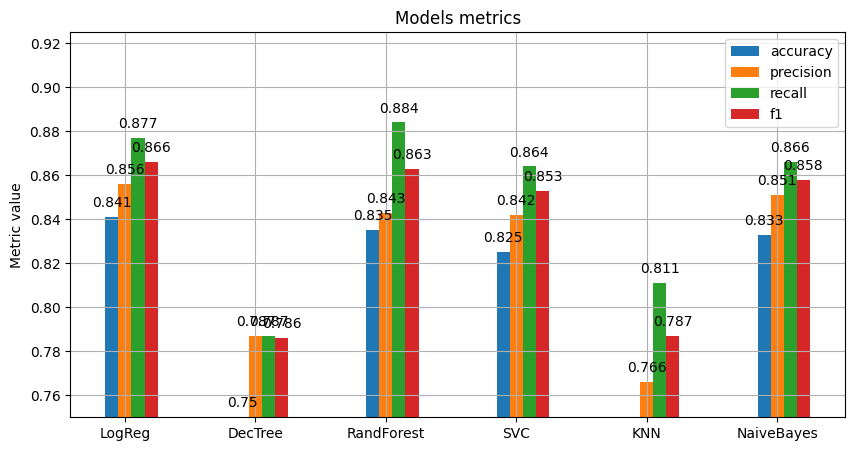

In [7]:
all_results = {metric_name: [] for metric_name in metrics.keys()}

for model, results in test_results.items():
    for metric, value in results.items():
        all_results[metric].append(np.array(value).mean())

x_loc = np.arange(len(models))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5))

for attribute, measurement in all_results.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, np.round(measurement, 3), width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.set_ylabel('Metric value')
ax.set_title('Models metrics')
ax.set_xticks(x_loc + width, [v[0] for v in models.values()])
ax.legend()
ax.grid()
ax.set_ylim(0.75, 0.925)

plt.show()

We can see that **Decision Tree** and **KNN** showed worst results in all metrics, hence we immediately drop them. **Random Decision Tree** demonstrated highest `recall` score compared to all models, but it showed sligtly worse results in other metrics, so we cannot pick this model right away either. On average it looks like **Logistic regression** model showed one of the best results, therefore, let us use this model for the predictions.